In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [47]:
from helpers import *


In [3]:
!pip install tensorflow-addons
!pip install pydot


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental import preprocessing
import pprint
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio.io
import sys
import rasterio.features
import rasterio.warp
from rasterio.plot import show
import warnings
#import helpers as helpers
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) <= parse_version("2.6.0"), \
    f"Please install TensorFlow version 2.6.0 or older. Your current version is {tf.__version__}."

print("Python version: " + sys.version)

Tensorflow 2.5.0
Python version: 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


In [49]:
DATASET_ROOT_PATH = '../../data/HiltonOfFern_crop_field_training_cloud_free_available_area'
HALF_MAX_RGB_INTENSITY = 9144.0
BATCH_SIZE = 1

list_ds = tf.data.Dataset.list_files(DATASET_ROOT_PATH + '/*/*/S2/Patches/*.tif', shuffle=True)

# Reducing amount of data whilst getting stuff working. remember to comment out/delete this when finished!!!!!!!!!!!!!!
#list_ds = list_ds.skip(4500)

total_products = tf.data.experimental.cardinality(list_ds).numpy()
print("total products = " + str(total_products))
list_ds = list_ds.filter(cloudy_or_black_images_filter)
# unfortunately filtering sets the cardinality for the dataset to -2 (unkown) so have to manually set it or will cause an error
# when try to iterate through dataset during training
list_ds = list_ds.apply(tf.data.experimental.assert_cardinality(len(list(list_ds))))
total_products = tf.data.experimental.cardinality(list_ds).numpy()
print("total products after filtering cloudy images = " + str(total_products))


test_size = int(total_products * 0.2)
print("test size = " + str(test_size))
train_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)
print("have split into train and test")
print("train has size " + str(tf.data.experimental.cardinality(train_ds).numpy()) + " whilst test has size " + str(tf.data.experimental.cardinality(test_ds).numpy()))
train_ds = train_ds.map(process_path)
train_ds.apply(tf.data.experimental.ignore_errors())
# rescale sentinel 2 rgb values to between -1 and 1 (as we use tan for generator output)
rescaling_layer = Rescaling(scale = 1./HALF_MAX_RGB_INTENSITY, offset=-1.)
train_ds = train_ds.map(lambda x, y: (x, rescaling_layer(y)))


train_ds = train_ds.batch(BATCH_SIZE).repeat()
print("finished preparing training data")




test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds.apply(tf.data.experimental.ignore_errors())
# rescale sentinel 2 rgb values to between -1 and 1 (consistentg with test data which is set to -1 and 1 due to generator outputing tan)
test_ds = test_ds.map(lambda x, y: (x, rescaling_layer(y)))
test_ds = test_ds.batch(BATCH_SIZE).repeat()
print("finished preparing validation data")

total products = 7069
total products after filtering cloudy images = 1056
test size = 211
have split into train and test
train has size 845 whilst test has size 211
finished preparing training data
finished preparing validation data


In [50]:
input_image_shape = (256, 256, 2)
output_image_shape = (256, 256, 3)
class PIX2PIX():
    #def __init__(self, input_shape):
    def __init__(self):
        #self.input_shape = input_shape

        # discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = False
        self.optimizer_discriminator = Adam(2e-4, 0.5, 0.9999)
                
        # build generator pipeline with frozen discriminator
        self.generator = self.build_generator()
        discriminator_output = self.discriminator([self.generator.input, 
                                                   self.generator.output])
        self.patch_size = discriminator_output.shape[1]
        self.model = Model(self.generator.input, [discriminator_output, self.generator.output])
        self.LAMBDA = 100
        self.model.compile(loss = ['bce','mae'],
                           optimizer = Adam(2e-4, 0.5, 0.9999),
                           loss_weights=[1, self.LAMBDA])
        self.discriminator.trainable = True
        self.bce = tf.keras.losses.BinaryCrossentropy()
        
    def bce_loss(self, y_true, y_pred):
        
        loss = self.bce(y_true, y_pred)

        return loss
    
    def downsample(self, channels, kernels, strides=2, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def upsample(self, channels, kernels, strides=1, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.UpSampling2D((2,2)))
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def build_generator(self):

        DIM = 64

        input_image = layers.Input(shape=input_image_shape)
        down1 = self.downsample(DIM, 4, norm=False)(input_image) # 128, DIM
        down2 = self.downsample(2*DIM, 4)(down1) # 64, 2*DIM
        down3 = self.downsample(4*DIM, 4)(down2) # 32, 4*DIM
        down4 = self.downsample(4*DIM, 4)(down3) # 16, 4*DIM
        down5 = self.downsample(4*DIM, 4)(down4) # 8, 4*DIM
        down6 = self.downsample(4*DIM, 4)(down5) # 4, 4*DIM
        down7 = self.downsample(4*DIM, 4)(down6) # 2, 4*DIM


        up6 = self.upsample(4*DIM, 4, dropout=True)(down7) # 4,4*DIM
        concat6 = layers.Concatenate()([up6, down6])   

        up5 = self.upsample(4*DIM, 4, dropout=True)(concat6) 
        concat5 = layers.Concatenate()([up5, down5]) 

        up4 = self.upsample(4*DIM, 4, dropout=True)(concat5) 
        concat4 = layers.Concatenate()([up4, down4]) 

        up3 = self.upsample(4*DIM, 4)(concat4) 
        concat3 = layers.Concatenate()([up3, down3]) 

        up2 = self.upsample(2*DIM, 4)(concat3) 
        concat2 = layers.Concatenate()([up2, down2]) 

        up1 = self.upsample(DIM, 4)(concat2) 
        concat1 = layers.Concatenate()([up1, down1]) 

        output_image = tanh(self.upsample(3, 4, norm=False, activation=False)(concat1))

        return Model(input_image, output_image, name='generator')         
    
    def build_discriminator(self):
        DIM = 64
        model = tf.keras.Sequential(name='discriminators') 
        input_image_A = layers.Input(shape=input_image_shape)
        input_image_B = layers.Input(shape=output_image_shape)
        
        x = layers.Concatenate()([input_image_A, input_image_B])
        x = self.downsample(DIM, 4, norm=False)(x) # 128
        x = self.downsample(2*DIM, 4)(x) # 64
        x = self.downsample(4*DIM, 4)(x) # 32
        x = self.downsample(8*DIM, 4, strides=1)(x) # 29
        output = layers.Conv2D(1, 4, activation='sigmoid')(x)

        return Model([input_image_A, input_image_B], output)     
    
    def train_discriminator(self, real_images_A, real_images_B, batch_size):
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))
         
        fake_images_B = self.generator.predict(real_images_A)
             
        with tf.GradientTape() as gradient_tape:
            
            # forward pass
            pred_fake = self.discriminator([real_images_A, fake_images_B])
            pred_real = self.discriminator([real_images_A, real_images_B])
            
            # calculate losses
            loss_fake = self.bce_loss(fake_labels, pred_fake)
            loss_real = self.bce_loss(real_labels, pred_real)           
            
            # total loss
            total_loss = 0.5*(loss_fake + loss_real)
            
            # apply gradients
            gradients = gradient_tape.gradient(total_loss, self.discriminator.trainable_variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return loss_fake, loss_real
    
    def train(self, data_generator, test_data_generator, batch_size, steps, interval=100):
        val_images = next(test_data_generator) 
        #print("val_images values below\n")
        tf.print(val_images[0].shape)
        tf.print(val_images[1].shape)
    
        
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))

        self.batch_size = batch_size
        for i in range(steps):
    
            real_images_A, real_images_B = next(data_generator)
            loss_fake, loss_real = self.train_discriminator(real_images_A, real_images_B, batch_size)
            discriminator_loss = 0.5*(loss_fake + loss_real)
                
            # train generator
            g_loss = self.model.train_on_batch(real_images_A, [real_labels, real_images_B])
            if i%interval == 0:
                msg = "Step {}: discriminator_loss {:.4f} g_loss {:.4f}"\
                .format(i, discriminator_loss, g_loss[0])
                print(msg)
                
                fake_images = self.generator.predict(val_images[0])
                #print("fake images shape = " + str(fake_images.shape) + " pprint below \n")
                #pp.pprint(fake_images)
                
                self.plot_images(val_images[1], fake_images)
            
    def plot_images(self, real_images, fake_images):   
        grid_row = min(fake_images.shape[0], 4)
        print("grid_row = " + str(grid_row) + "\n")
        grid_col = 2
        
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*6, grid_row*6))
        for row in range(grid_row):
            ax = axarr if grid_row==1 else axarr[row]
            #ax[0].imshow((real_images[0][row]+1)/2)
            #ax[0].axis('off') 
            #ax[1].imshow((real_images[1][row]+1)/2)
            ax[0].imshow((real_images[row]+1)/2)
            ax[0].axis('off') 
            ax[1].imshow((fake_images[row]+1)/2)
            ax[1].axis('off') 
        plt.show()
        
    def sample_images(self, number):
        z = tf.random.normal((number, self.z_dim))
        images = self.generator.predict(z)
        self.plot_images(images)
        return images

pix2pix = PIX2PIX()

In [ ]:
tf.keras.utils.plot_model(pix2pix.generator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(pix2pix.discriminator, show_shapes=True)

TensorShape([1, 256, 256, 2])
TensorShape([1, 256, 256, 3])
Step 0: discriminator_loss 0.7666 g_loss 70.8398
grid_row = 1



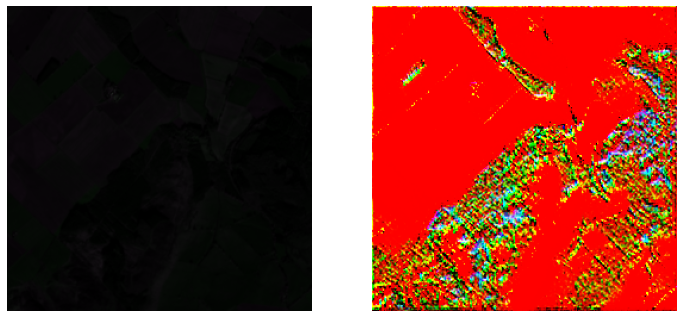

Step 50: discriminator_loss 0.7090 g_loss 2.3987
grid_row = 1



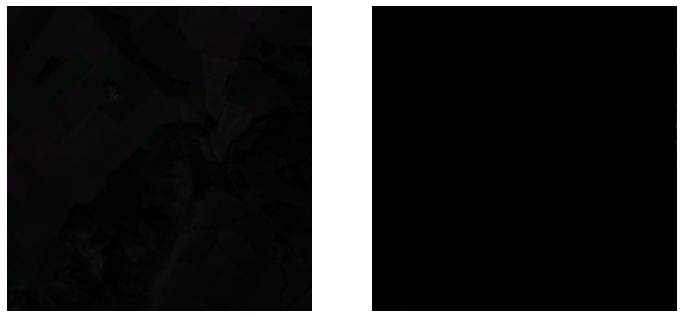

Step 100: discriminator_loss 0.7023 g_loss 8.3889
grid_row = 1



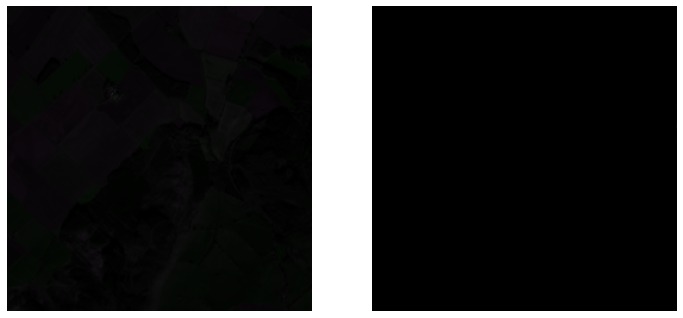

Step 150: discriminator_loss 0.7012 g_loss 5.0241
grid_row = 1



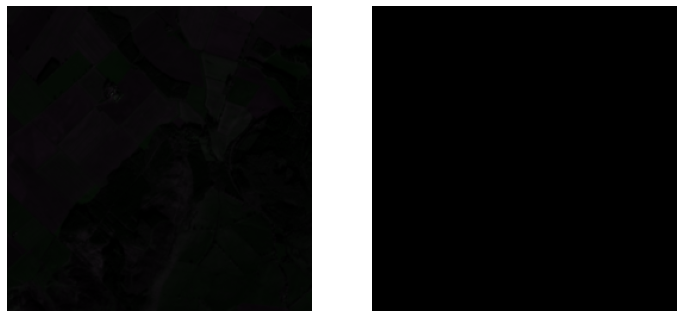

Step 200: discriminator_loss 0.6966 g_loss 4.6704
grid_row = 1



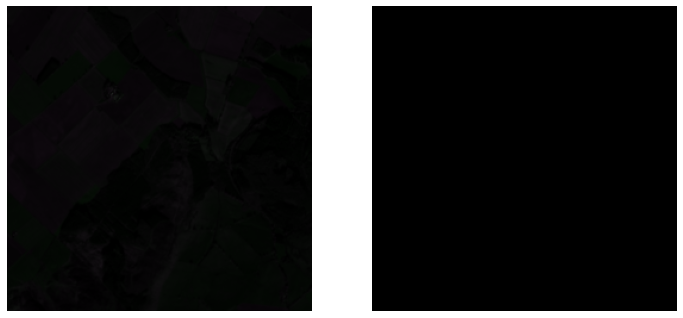

PermissionDeniedError: /saved_weights; Permission denied

In [51]:
pix2pix.train(iter(train_ds), iter(test_ds), BATCH_SIZE, 250, 50)
pix2pix.generator.save("/saved_weights/pix2pix_sentinelv1")